# Modeling Observations

This notebook allows us to simulate "observing" our ocean or atmosphere systems.

- Later, we plan to use ocean observations to try to improve the estimates of the atmosphere state.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import helper
from scipy.interpolate import griddata


We borrow the following functionality from previous notebooks, saved in the helper.py file:

- ```helper.generate_world(nr, nc, dt, F, num_gauss=16, num_circles=20, radius=5, values=[2,-2], std_dev=2)```

- ```helper.compute_affine_time_evolution_simple(c0, M, r, num_saved_timesteps, duration_per_saved_timestep, debug = False)```

- ```helper.plot_multi_heatmap(many_states, nr, nc, titles, big_title, vmin=None, vmax=None)```

- ```helper.plot_multi_heatmap_evolution(saved_timesteps, many_states_over_time, nr, nc, titles, big_title, vmin=None, vmax=None, is_1d=False)```

- ```helper.compute_covariance_matrix_gaussian_dropoff(nr, nc, std_dev=1)```

- ```helper.generate_random_vectors_mean_0_cov_C(nr, nc, C, num_vectors)```



We'll create some sample data to test out our new tools:

In [2]:
# Use function to create a random model
nr, nc = 32,32
dt = 0.01
F  = 0.01

C, c0, f, M = helper.generate_world(nr, nc, dt, F)

num_saved_timesteps = 10
duration_per_saved_timestep = 20

saved_timesteps, state_over_time = helper.compute_affine_time_evolution_simple(c0, M, F*f, 
                                            num_saved_timesteps, duration_per_saved_timestep)



-------
# Ocean Sampling
-------

Now, we have a completed ocean model.

But in real life, we can't actually know the ocean state perfectly. Rather, we might only get to observe certain points in space, at certain points in time.

So, we'd like to **model** those observations, and how we can use them to estimate the state of the ocean.


### Observation

Here's how we'll generate these observations:

- Each observation will observe a random grid cell on our world map.

- Each observation will have some gaussian noise added (to represent inaccuracy in the observer)


In [3]:
def observe(real, sigma, num_observations):
    """
    Generates noisy observations of a true state at randomly selected indices.

    Args:
    real (np.ndarray): The true state of the system, as a 1D array
    sigma (float): The standard deviation of the observation noise
    num_observations (int): The number of observations to make

    Returns:
    tuple: (indices, observations)
        indices (np.ndarray): Array of randomly selected indices for observation
        observations (np.ndarray): Noisy observations of the true state at the selected indices

    Notes:
    - Observations are made by adding Gaussian noise to the true state values
    - The noise is generated as a 2D column vector
    - Indices are selected without replacement, ensuring unique observation points
    """
    # We randomly select which indices to observe
    indices = np.random.choice(len(real), num_observations, replace=False)

    # We observe the true state plus Gaussian noise
    noise = np.random.normal(0, sigma, (num_observations, 1))
    
    observations = real[indices] + noise

    return indices, observations

### Filling our map with observations

Now, we want to place these observations all over our map, ignoring grid cells we haven't observed.

- We'll do this by creating a full map, where every unobserved grid cell is given by a NaN value.

In [4]:
def fill_nan_map_with_observations(indices, observations, nr, nc):
    """
    Maps observations to their corresponding positions in a 2D grid, filling the rest with NaNs.

    Args:
    indices (np.ndarray): Indices of the observations in the flattened grid
    observations (np.ndarray): Observed values
    nr (int): Number of rows in the grid
    nc (int): Number of columns in the grid

    Returns:
    np.ndarray: 2D array with observations at their corresponding positions and NaNs elsewhere
    """
    observed_state_2d = np.full((nr, nc), np.nan)
    observed_state_2d.flat[indices] = observations.flatten()
    return observed_state_2d

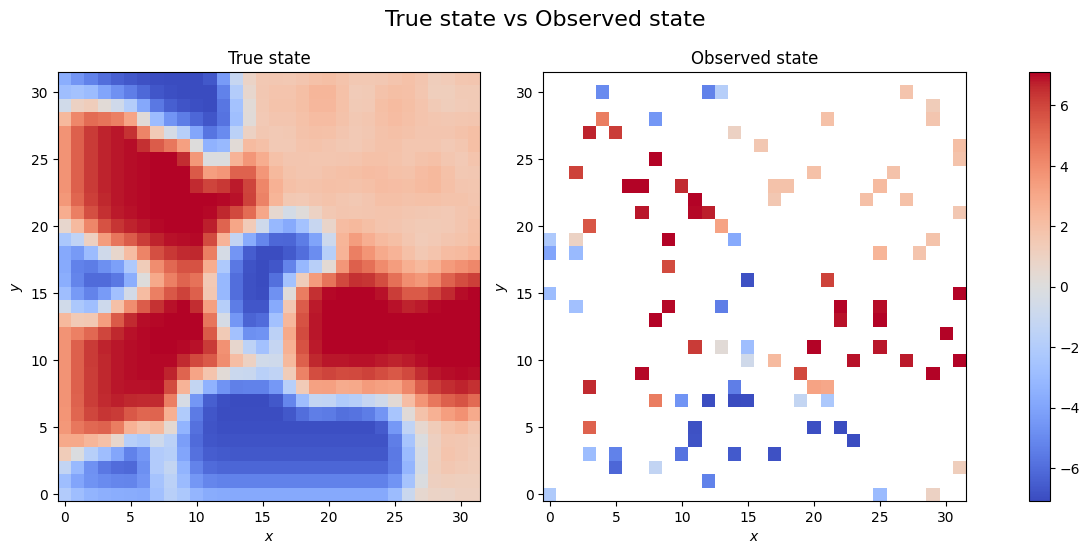

In [5]:
# Create a bunch of observations from our state at time 0, and then create a NaN map

num_observations = 100
sigma = 0.1
state = state_over_time[0]

indices, observations = observe(state, sigma, num_observations)
observed_state_2d     = fill_nan_map_with_observations(indices, observations, nr, nc)
observed_state        = np.reshape(observed_state_2d, (nr*nc, 1))

# Plot state and observed_state 
helper.plot_multi_heatmap([state, observed_state], nr,nc, ["True state", "Observed state"], "True state vs Observed state")


### Interpolation

We can try to use our limited observations to guess what the ocean looks like overall: we'll use some simple interpolation (smoothly "averaging" between nearby pixels) to make this estimate.

In [6]:
def interpolate_observation_map(observed_state_2d, extend=False):
    """
    Interpolates a 2D grid of observed values, to fill in NaN values (representing unobserved points).

    Args:
    observed_state_2d (np.ndarray): 2D array with observed values and NaNs
    extend (bool, optional): If True, extends the observed state by three copies horizontally. Defaults to False.

    Returns:
    np.ndarray: 2D array of interpolated values

    Notes:
    - If extend is True:
        - The observed state is extended by three copies horizontally
        - Interpolation is performed on the extended grid
        - The middle third of the interpolated result is returned
    - If extend is False:
        - Interpolation is performed on the original grid
    - Linear interpolation is used, with NaN values for points outside the convex hull of observations
    """
    nr, nc = observed_state_2d.shape

    if extend:
        # Extend state by three copies
        observed_state_2d = np.hstack((observed_state_2d, observed_state_2d, observed_state_2d))
    
    extended_nr, extended_nc = observed_state_2d.shape
    
    # Create grid coordinates
    x, y = np.meshgrid(np.arange(extended_nc), np.arange(extended_nr))
    
    # Find non-NaN indices and values
    observed_indices = np.where(~np.isnan(observed_state_2d.flatten()))[0]
    observed_values = observed_state_2d.flatten()[observed_indices]
    
    # Create points and grid for interpolation
    points = np.column_stack((x.flat[observed_indices], y.flat[observed_indices]))
    grid_x, grid_y = np.meshgrid(np.arange(extended_nc), np.arange(extended_nr))
    
    # Perform interpolation
    interpolated_2d = griddata(points, observed_values, (grid_x, grid_y), method='linear', fill_value=np.nan)
    
    if extend:
        # Extract the middle third
        return interpolated_2d[:, nc:2*nc]
    else:
        return interpolated_2d

Let's see what our observations look like:

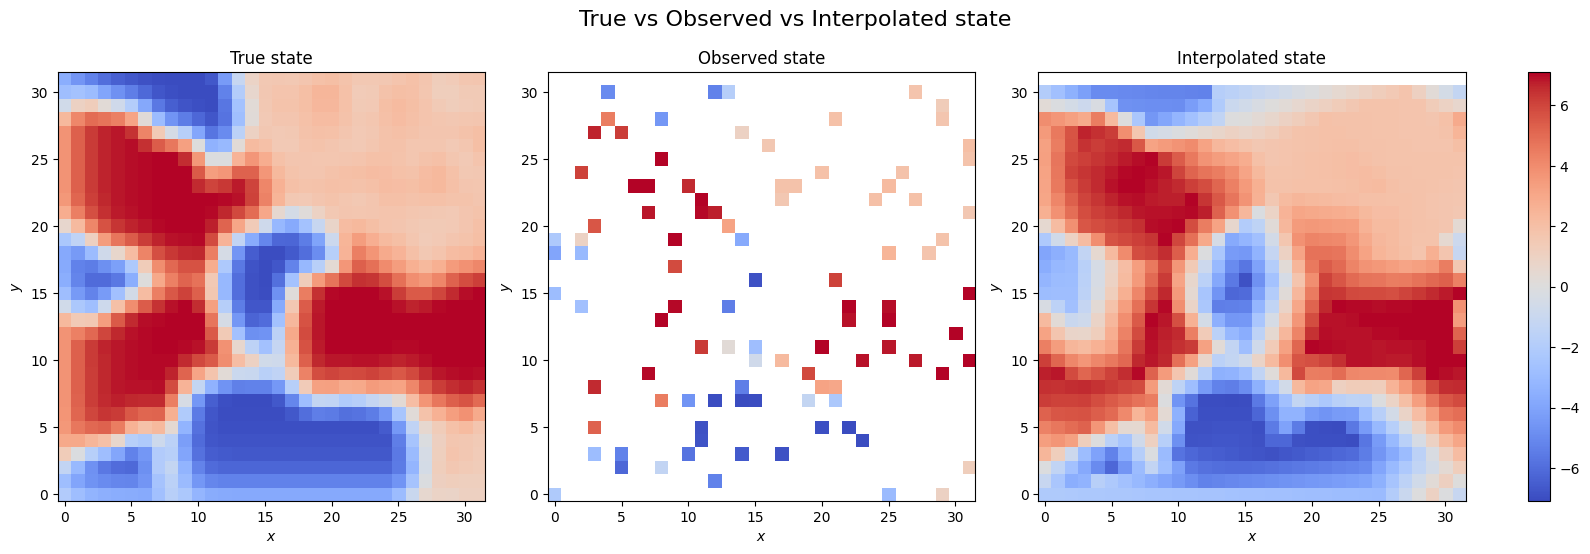

In [7]:
    
# Display the real state, the observed state, and the interpolated state using interpolate_nan_map

interpolated_state_2d = interpolate_observation_map(observed_state_2d, extend=True) #2d
interpolated_state = np.reshape(interpolated_state_2d, (nr*nc, 1))


helper.plot_multi_heatmap([state, observed_state, interpolated_state], nr,nc, 
                              ["True state", "Observed state", "Interpolated state"], "True vs Observed vs Interpolated state")

Here, we can see that the interpolated version is similar to what we expected, but has some distortion: our model is somewhat inaccurate.

- This should make sense: our data is limited, so we can't perfectly guess the state everywhere.

### Ocean model over time

Now, we want to observe our ocean model over many timesteps.

In [8]:
def observe_over_time(ocean_states, sigma, num_obs_per_timestep, nr, nc):
    """
    Observes the ocean state at each timestep, and places those observations in
    a 2d array with NaNs for unobserved points.

    Args:
    ocean_states (list): List of ocean states at each timestep, each as a 2d array
    sigma (float): Standard deviation of observation noise
    num_obs_per_timestep (int): Number of observations per timestep
    nr (int): Number of rows in the grid
    nc (int): Number of columns in the grid

    Returns:
    list: List of observed ocean states at each timestep, each as a 2D array with NaNs for unobserved points

    """
    # Observe ocean state at each timestep
    indices_and_observations_over_time = [observe(ocean_state, sigma, num_obs_per_timestep) 
                                            for ocean_state in ocean_states]
    
    # Place on a map: unobserved points are filled with NaN
    observed_state_over_time_2d = [fill_nan_map_with_observations(indices, observations_t, nr, nc) 
                                    for indices, observations_t in indices_and_observations_over_time]
    
    return observed_state_over_time_2d

We'll compare the true ocean state at each time to the one we observe.

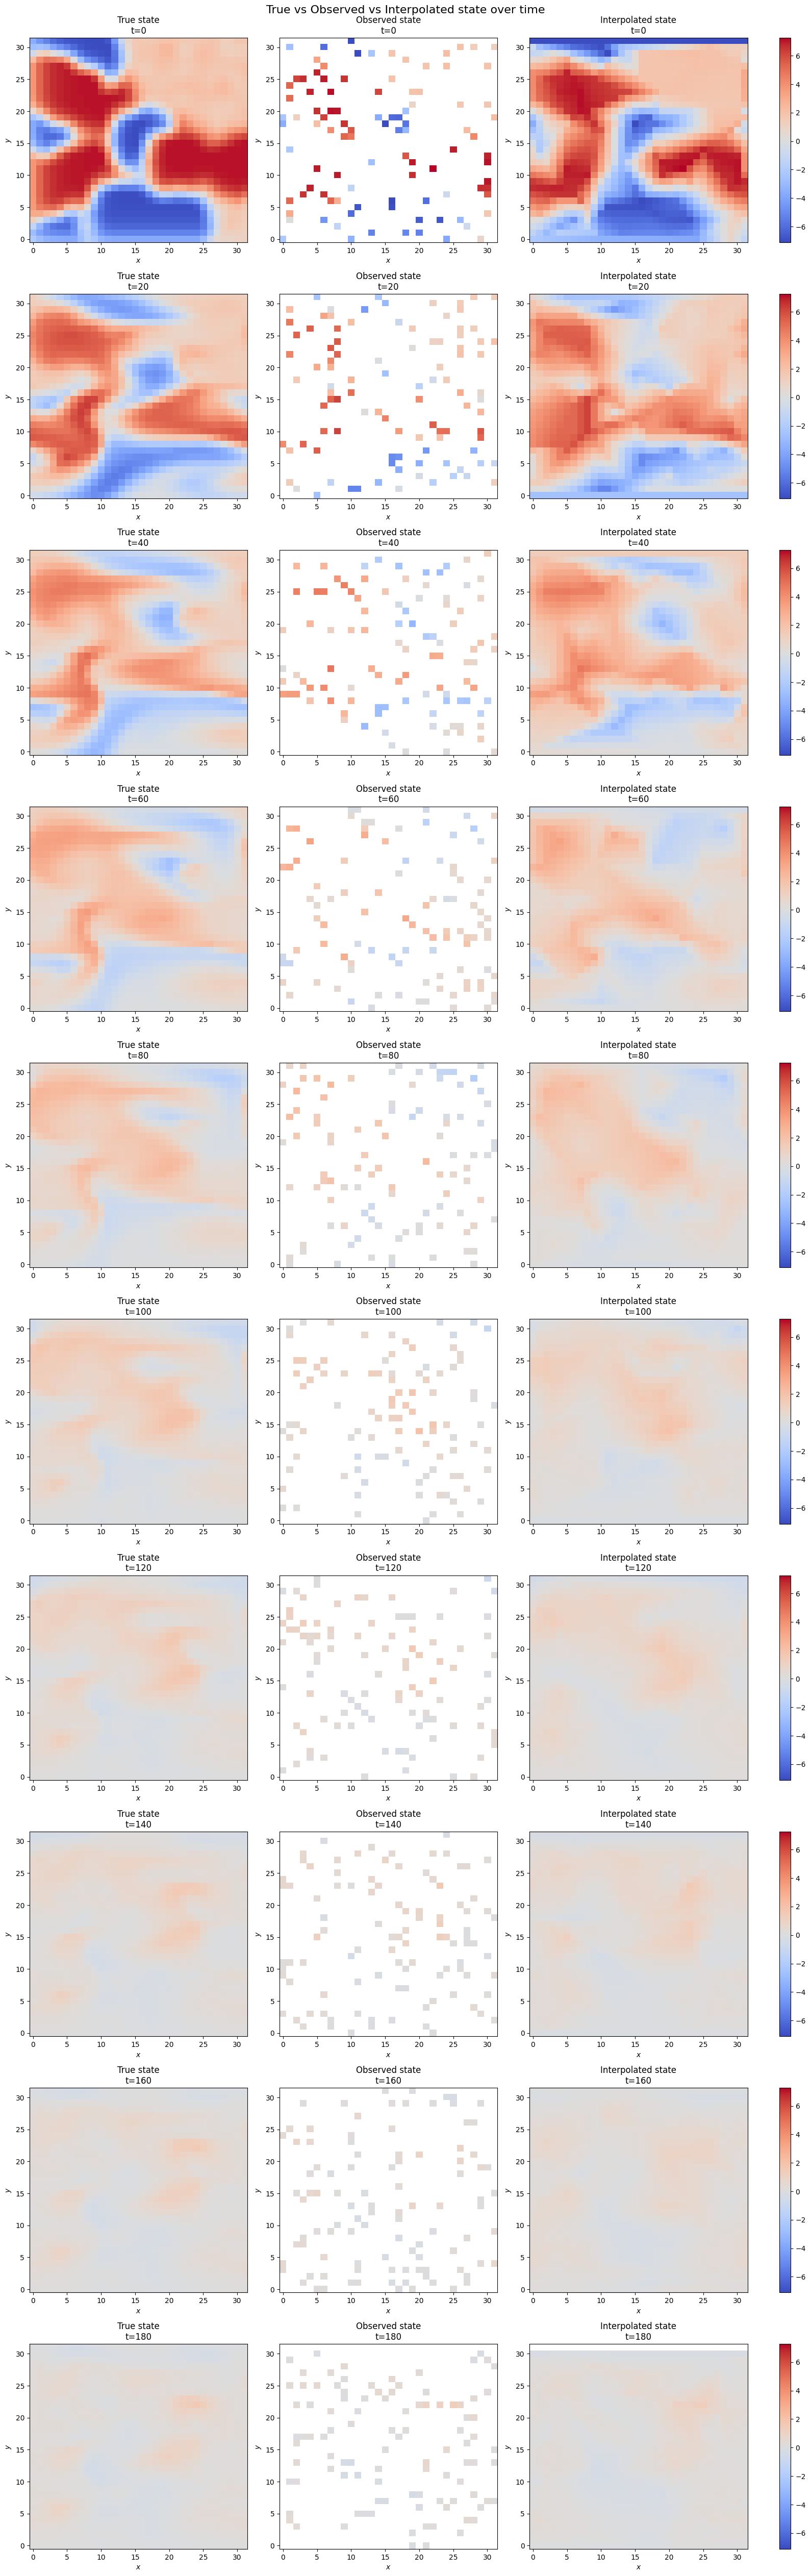

In [9]:
# First, we observe the ocean state over time
sigma = 0.1
num_obs_per_timestep = 100

observed_state_over_time_2d = observe_over_time(state_over_time, sigma, num_obs_per_timestep, nr, nc)

# Then, we interpolate the observed states over time
interpolated_state_over_time_2d = [interpolate_observation_map(observed_state_2d, extend=True) 
                                for observed_state_2d in observed_state_over_time_2d]

# Plot the true state, the observed state, and the interpolated state over time: must be 1d

observed_state_over_time =     [np.reshape(observed_state_2d, (nr*nc, 1)) 
                                for observed_state_2d in observed_state_over_time_2d]
interpolated_state_over_time = [np.reshape(interpolated_state_2d, (nr*nc, 1)) 
                                for interpolated_state_2d in interpolated_state_over_time_2d]

helper.plot_multi_heatmap_time_evolution(saved_timesteps, [state_over_time, observed_state_over_time, interpolated_state_over_time], nr,nc,
                                ["True state", "Observed state", "Interpolated state"], 
                                "True vs Observed vs Interpolated state over time")






-------
# Atmospheric Inaccuracy
-------

### Creating a "first-guess" atmosphere

In the same way that we can't perfectly measure the ocean, we can't perfectly measure the atmosphere. Once we've assembled our limited data, we can make a *guess*, trying to estimate the true atmosphere.

We'll call this a "first-guess" atmosphere: this is a prediction for the atmosphere state, which we can compare against the "true" atmosphere.

We want a few things from this first guess:

- It should look *similar* to our true atmosphere: it should be a pretty good guess.

- It should have the correct covariance: it has the right kind of structure we'd expect from our atmosphere.


### Breaking up our atmosphere into components
We'll accomplish this by breaking up our atmosphere into two parts: each of these components will be a random normal vector, like $f$ was before. We'll consider the two parts of our atmosphere:

- The *shared* part, common between both the true and first-guess atmosphere. This will make sure they're both similar. We'll call this part $f_0$.

- The *unshared* part: this will represent the inaccuracy of our first guess. The true version will be $f_1$, and the first-guess will be $f_2$.

$$f_{true} = f_0 + f_1 \qquad \qquad \qquad f_{guess} = f_0 + f_2$$

In order to make sure that both atmospheres have the same statistical structure:
- $f_0$, $f_1$, and $f_2$ will all be normal vectors with **mean 0, covariance $C$**: this can be written as

$$f_0, f_1,f_2 \sim \mathcal{N}(0,C)$$

- But if we just add them together, we'll end up adding their covariances! So, we'll need to scale down each component. 

  - We'll use scaling factors $\gamma$ and $1-\gamma$: because they add to 1, we'll end up with the correct covariance (typically, you choose $\gamma \in (0,1)$).

$$f_{true} = \gamma f_0 + (1-\gamma) f_1 \qquad \qquad \qquad f_{guess} = \gamma f_0 + (1-\gamma) f_2$$

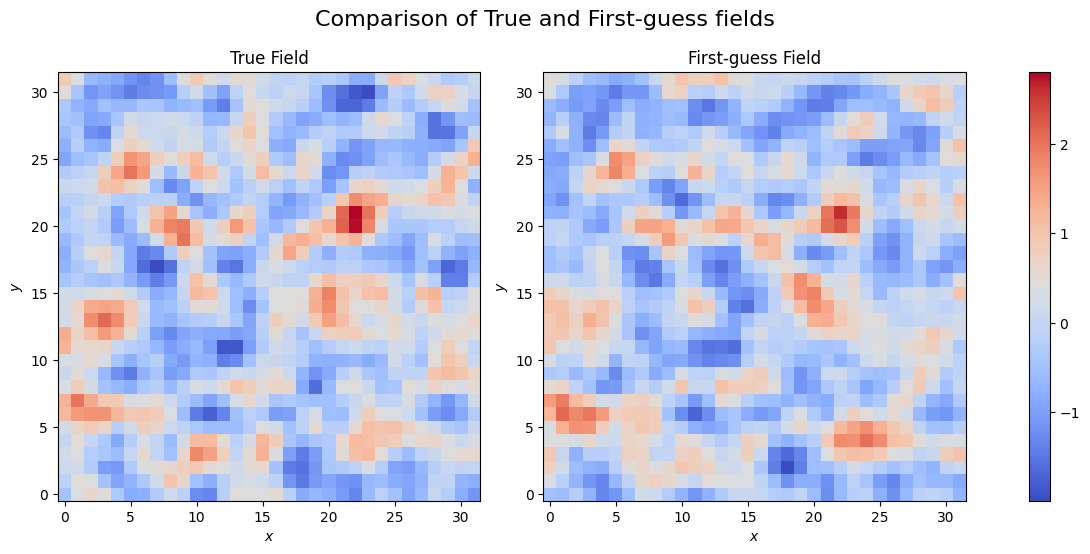

In [10]:
#Create our fake atmosphere, same way as the original
C = helper.compute_covariance_matrix_gaussian_dropoff(nr, nc)
f1,f2 = helper.generate_random_vectors_mean_0_cov_C(nr, nc, C, 
                                                    num_vectors=2)[1]
f0 = f 

gamma = 2/3
f_nature = f0 * gamma + f1 * (1-gamma)
f_guess  = f0 * gamma + f2 * (1-gamma)
helper.plot_multi_heatmap([f_nature, f_guess], nr, nc, 
                  ['True Field', 'First-guess Field'],
                  'Comparison of True and First-guess fields')


Based on this approach, we create a function that does this for us:

In [11]:
def generate_true_and_first_guess_field_uniform_cov(C, nr, nc, gamma):
    """
    Generates two fields: a true field and a first-guess field, both with the same covariance C.

    Args:
    C (np.ndarray): Covariance matrix for both fields
    nr (int): Number of rows in the grid
    nc (int): Number of columns in the grid
    gamma (float): Fraction of the field shared between true and first-guess fields

    Returns:
    tuple: (true_field, first_guess_field)
        true_field (np.ndarray): Random field with covariance C
        first_guess_field (np.ndarray): Random field sharing a component with true_field, covariance C

    Notes:
    - f2 replaces f1 in the "first-guess" field to represent inaccuracies
    - The shared component (f0) represents the fraction of the field that is 
      common between the true and first-guess fields
    """
    f0,f1,f2 = helper.generate_random_vectors_mean_0_cov_C(nr, nc, C, 3)[1]

    true_field        = f0 * gamma + f1 * (1-gamma)
    first_guess_field = f0 * gamma + f2 * (1-gamma)

    return true_field, first_guess_field


This approach, of course, restricts us to having the same covariance for the "shared" signal $f_0$, and the "error" signal $f_2-f_1$.

Here's an alternate version we could use if we wanted them to have different statistical structure (given by covariance): 

In [12]:
def generate_true_and_first_guess_field(C_known, C_error, nr, nc):
    """
    Generates two fields: a true field and a first-guess field, both with specified covariances.

    Args:
    C_known (np.ndarray): Covariance matrix for the known part of the field
    C_error (np.ndarray): Covariance matrix for the error part of the field
    nr, nc (int): Dimensions of the 2D grid

    Returns:
    tuple: (true_field, first_guess_field)
        true_field (np.ndarray): Random field with covariance C_known + C_error
        first_guess_field (np.ndarray): Random field sharing a component with true_field, covariance C_known + C_error

    Notes:
    - f2 replaces f1 in the "first-guess" field to represent inaccuracies
    - The shared component (f0) represents the fraction of the field that is 
      common between the true and first-guess fields
    """
    f0 = helper.generate_random_vectors_mean_0_cov_C(nr, nc, C_known, 1)[1][0]
    f1, f2 = helper.generate_random_vectors_mean_0_cov_C(nr, nc, C_error, 2)[1]

    print(f0.shape, f1.shape, f2.shape)

    true_field = f0 + f1
    first_guess_field = f0 + f2

    return true_field, first_guess_field

# Generate true and first-guess fields
C_known = helper.compute_covariance_matrix_gaussian_dropoff(nr, nc)
C_error = helper.compute_covariance_matrix_gaussian_dropoff(nr, nc)
true_field, first_guess_field = generate_true_and_first_guess_field(C_known, C_error, nr, nc)


(1024, 1) (1024, 1) (1024, 1)


### Simulating our First-Guess Field

We can now contrast these two fields, in how they affect our ocean state over time.

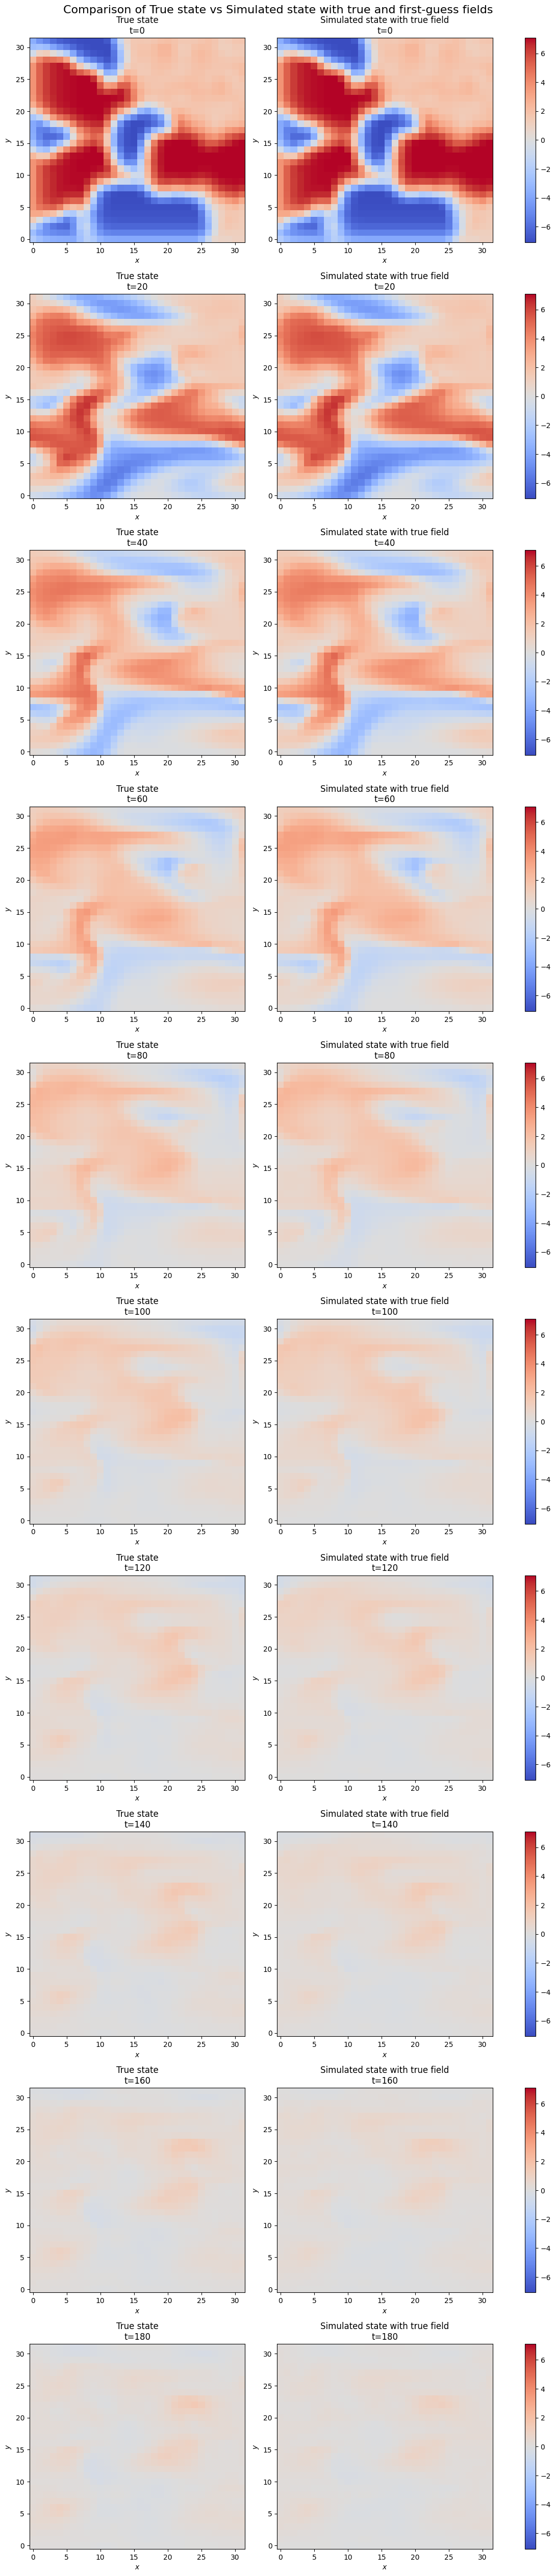

In [13]:

# How does the state evolve if we use the first-guess field, instead of the true field?
saved_timesteps, guess_state_over_time = helper.compute_affine_time_evolution_simple(c0, M, F*f_guess, 
                                            num_saved_timesteps, duration_per_saved_timestep)


# Plot the true state, and the state we simulate 
helper.plot_multi_heatmap_time_evolution(saved_timesteps=saved_timesteps,
                                    many_states_over_time=[state_over_time, guess_state_over_time],
                                    nr=nr, nc=nc,
                                    titles=["True state", "Simulated state with true field", "Simulated state with first-guess field"],
                                    big_title="Comparison of True state vs Simulated state with true and first-guess fields",
                                    vmin=None, vmax=None)
